# LTLF with SARIMAX 

In [58]:
!conda env create -f thesis.yml
!conda activate thesis
!python -m ipykernel install --user --name=thesis


CondaValueError: prefix already exists: C:\Users\Dimitrije\anaconda3\envs\thesis



Installed kernelspec thesis in C:\Users\Dimitrije\AppData\Roaming\jupyter\kernels\thesis


In [59]:
import numpy as np
import pandas as pd
import pandera as pa
from typing import Type, Optional
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta
import datetime

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

import meteostat as met

## Data Cleaning

The first thing that needs to happen so that we can perform a time series analysis is the conversion of dates and settlement periods into actual datetime objects. I will use the Pandas builtin `.to_datetime` for most of the parsing, but there are multiple date formats in the data, so I will have to treat each individually. I then write some functions to aid in converting settlement periods to DateTimes

In [60]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [61]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [62]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [63]:
# List comprehensions are slightly faster than hidden for-loops in apply, and make sure that to_datetime doesn't fall back to dateutil.parser.parse
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [64]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [65]:
# timeseries data breakout
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [66]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


## Regression: SARIMA (TS only)
### Train and Test Data; Functions

First, I split the data into a training and test set. Then I write some functions to be used in the TS analysis. Finally, I get the SARIMAX results.

N.B. The variable naming convention:

- `lt..` denotes long-term data (monthly over years)
- `st..` denotes short-term data (daily over one year)
- `..ts` denotes timeseries data (univariate)
- `..ex` denotes panel data (multivariate)

In [67]:
# sm complained that ND was not numeric
df["ND"] = pd.to_numeric(df["ND"], errors="coerce")

In [68]:
ltts = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

ltts_train = ltts[(ltts.index >= pd.to_datetime("2011-01-01")) & (ltts.index < pd.to_datetime("2022-01-01"))]

ltts_test = ltts[ltts.index >= pd.to_datetime("2022-01-01")]

In [69]:
def s_decomp_plot(data: Series, period: int) -> None:
    """
    Plots the seasonal decomposition of a timeseries based on the given period
    """
    decomp = sm.tsa.seasonal_decompose(data, period=period)

    trend = decomp.trend
    seasonal = decomp.seasonal
    resid = decomp.resid

    plt.figure(figsize=(15, 8))

    plt.subplot(411)
    sns.lineplot(data=data, color="blue")
    plt.xlabel("")
    plt.ylabel("National Demand (MW)")
    plt.legend().remove()

    plt.subplot(412)
    sns.lineplot(data=trend, color="orange")
    plt.xlabel("")
    plt.ylabel("Trend")

    plt.subplot(413)
    sns.lineplot(data=seasonal, color="green")
    plt.xlabel("")
    plt.ylabel("Seasonality")

    plt.subplot(414)
    sns.lineplot(data=resid, color="red")
    plt.xlabel("Year")
    plt.ylabel("Residual")

    plt.tight_layout()
    plt.show()

In [70]:
def selection_stationarity_diff(data: Series, lag_val: int) -> None:
    """
    Plots the ACF and PACF for the timeseries, as well as the differenced timeseries. Checks for stationarity of both explicitly (ADF)
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data, lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data, lags=lag_val, ax=ax[1])
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(data.diff(), lags=lag_val, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data.diff(), lags=lag_val, ax=ax[1])
    plt.show()

    adf_test = adfuller(data)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")

    adf_test_diff = adfuller(data.diff().dropna())
    print(f"ADF Statistic (post diff): {adf_test_diff[0]}")
    print(f"p-value (post diff): {adf_test_diff[1]}")

In [71]:
def rmse_mape(fitted: Type[SARIMAXResultsWrapper], test_set: Series, exog: Optional = None) -> None:
    predictions = fitted.get_forecast(steps=len(test_set), exog=exog)
    predicted_mean = predictions.predicted_mean

    rmse = RMSE(test_set, predicted_mean)
    mape = MAPE(test_set, predicted_mean)
    
    print(f"Root Mean Squared Error: {rmse}\nMean Average Percentage Error: {mape*100:.3f}%")

In [72]:
def grid_search_sarimax(data: Series, exog: Optional = None, p_list: list = [0,1,2], d_list: list = [1], q_list: list = [1,2], s_period: list = [12]) -> None:
    """
    Performs a grid search based on AIC to select best parameters for SARIMA(X) model
    """
    p = P = p_list
    q = Q = q_list
    d = D = d_list
    s = s_period

    pdq = list(itertools.product(p, d, q))
    s_pdq = list(itertools.product(P, D, Q, s))

    best_aic = float("inf")
    best_pdq = None
    best_s_pdq = None

    candidate_model_sarima = None
    candidate_fit_sarima = None

    for order in pdq:
        for s_order in s_pdq:
            try:
                candidate_model_sarima = SARIMAX(data, exog=exog, order=order, seasonal_order=s_order)
                candidate_fit_sarima = candidate_model_sarima.fit(disp=False, maxiter=1000, method='powell')
                
                if candidate_fit_sarima.aic < best_aic:
                    best_aic = candidate_fit_sarima.aic
                    best_pdq = order
                    best_s_pdq = s_order
            
            except:
                continue

    print(f"Best pdq: {best_pdq}\nBest PDQ: {best_s_pdq}\nAIC: {best_aic}")

In [73]:
def plot_fcast_sarimax(fitted: Type[SARIMAXResultsWrapper], train_set: Series, test_set: Series, exog: Optional = None) -> None:
    """
    Plots the training and test data, with forecast and confidence overlaid
    """
    fcast = fitted.get_forecast(steps=len(test_set), exog=exog)
    
    fcast_values = fcast.predicted_mean
    conf_int = fcast.conf_int()

    actualized_df = pd.concat([train_set, test_set])


    plt.figure(figsize=(15, 5))
    plt.plot(train_set, label="Training Data", color="C0")
    plt.plot(test_set, label="Test Data",color="C0")
    plt.plot(fcast_values, label="Forecast", color="orange")

    plt.fill_between(fcast_values.index, 
        conf_int.iloc[:, 0], 
        conf_int.iloc[:, 1], color="orange", alpha=0.1)

    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Values")
    
    plt.show()

### Model Selection (TS)

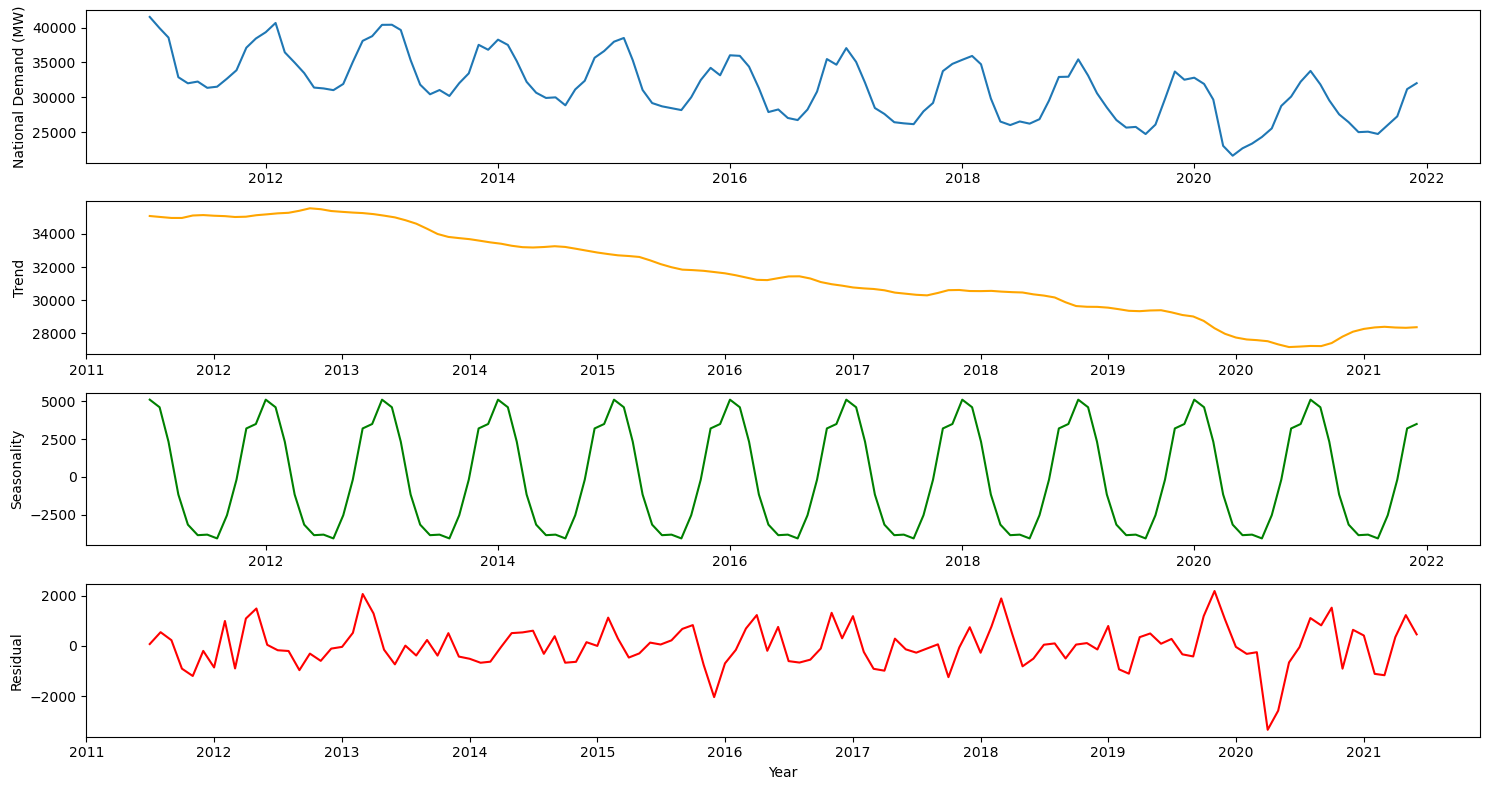

In [74]:
s_decomp_plot(ltts_train, 12)

I'll do one the old-fashioned way before I do a grid search.

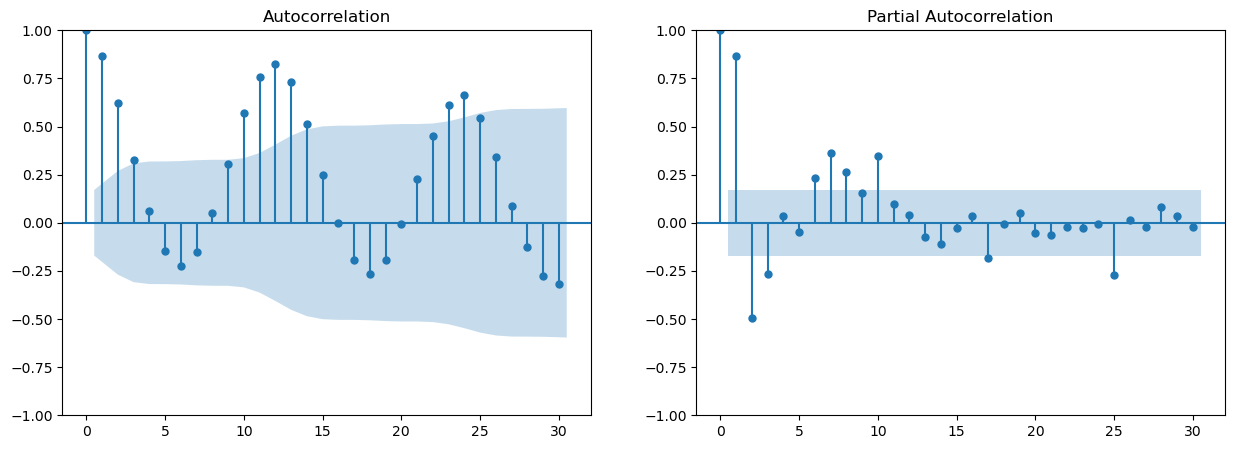

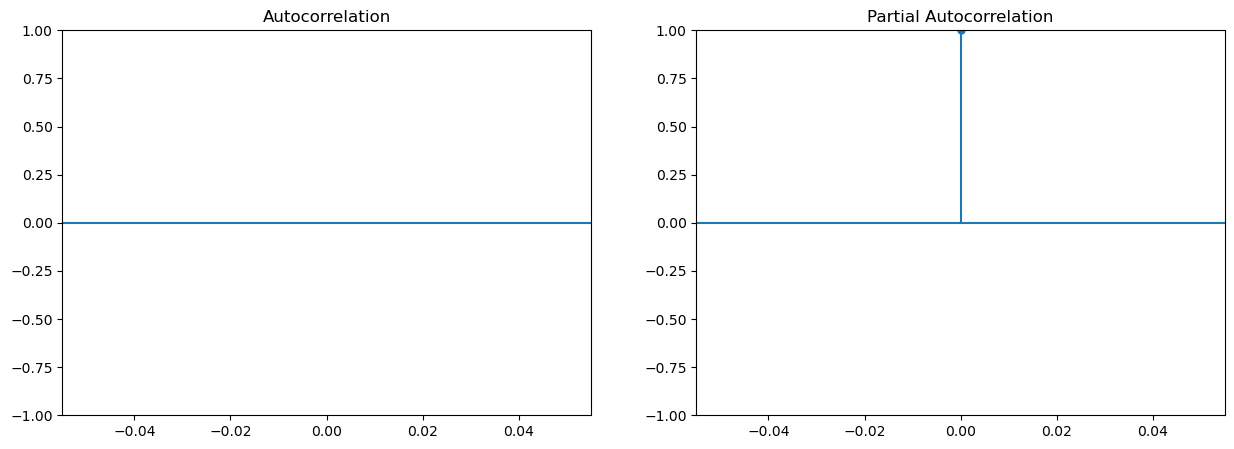

ADF Statistic: -0.6222989782285488
p-value: 0.8658633473639568
ADF Statistic (post diff): -8.570489233800481
p-value (post diff): 8.223096059429689e-14


In [75]:
selection_stationarity_diff(ltts_train, 30)

See the clear spikes at 2 in the ACF (MA component), and 1 in the PACF (AR component). Data is not stationary before differencing, so I(1).

In [76]:
ltts_model = SARIMAX(ltts_train, order=(1,1,2), seasonal_order=(1,1,2,12))
ltts_fit = ltts_model.fit(disp=False, maxiter=1000, method="powell")
print(ltts_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1028.512
Date:                            Tue, 23 Jul 2024   AIC                           2071.025
Time:                                    17:48:12   BIC                           2090.478
Sample:                                01-01-2011   HQIC                          2078.924
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2721      0.804      0.338      0.735      -1.303       1.847
ma.L1         -0.4302      0.791   

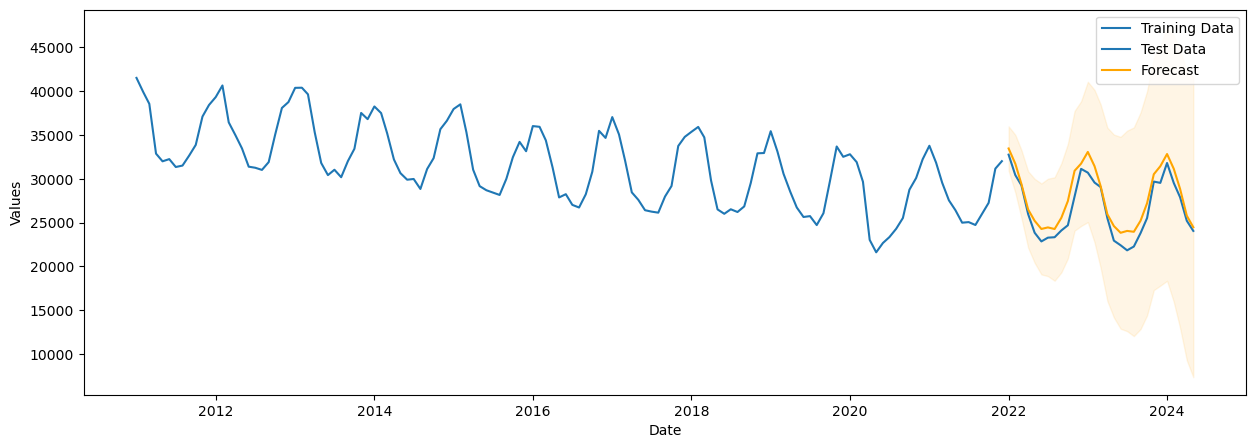

In [77]:
plot_fcast_sarimax(ltts_fit, ltts_train, ltts_test)

In [78]:
rmse_mape(ltts_fit, ltts_test)

Root Mean Squared Error: 1478.6302910176994
Mean Average Percentage Error: 4.998%


Not bad, but let's try the grid search.

### Final Model Results

In [79]:
#grid_search_sarimax(ltts_train)

No AR order, which is weird, and MA(1). The information criteria and MAPEs know better than I do.

In [80]:
ltts_model_grid = SARIMAX(ltts_train, order=(0,1,1), seasonal_order=(0,1,1,12))
ltts_fit_grid = ltts_model_grid.fit(disp=False, maxiter=1000, method="powell")
print(ltts_fit_grid.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ND   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1029.413
Date:                            Tue, 23 Jul 2024   AIC                           2064.826
Time:                                    17:48:12   BIC                           2073.164
Sample:                                01-01-2011   HQIC                          2068.212
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1602      0.071     -2.263      0.024      -0.299      -0.021
ma.S.L12      -0.3201      0.022   

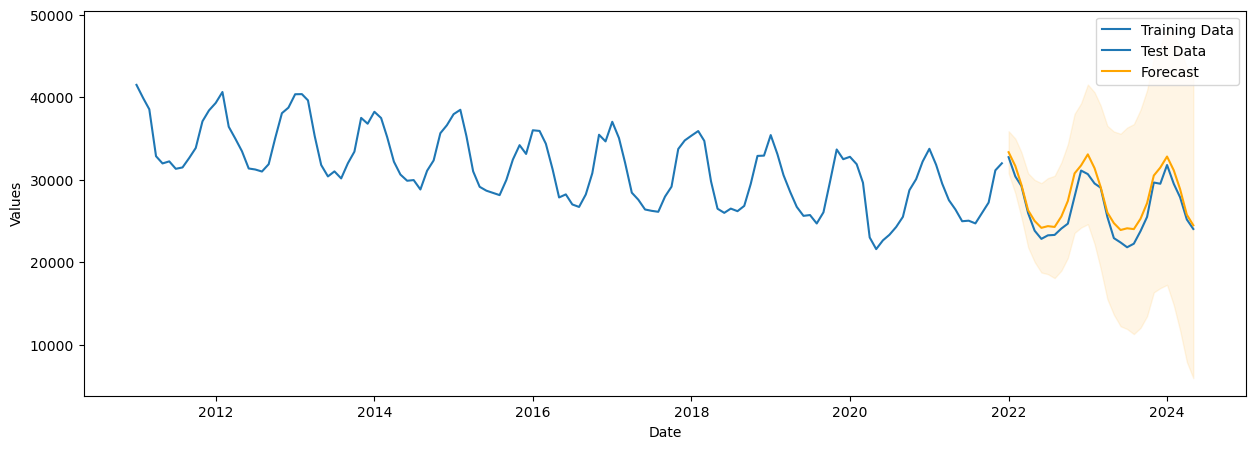

In [81]:
plot_fcast_sarimax(ltts_fit_grid, ltts_train, ltts_test)

In [82]:
rmse_mape(ltts_fit_grid, ltts_test)

Root Mean Squared Error: 1482.5004407132815
Mean Average Percentage Error: 5.007%


MAPE is barely higher, but AIC is lower, so grid search preferred.

## Regression: SARIMAX (Exogenous Variables Included)

### Collection of Weather Data

In [83]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)   # I want the full data from May

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [84]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

Now to average the monthly weather data and bring in the proxy for sun duration

In [85]:
sun_data_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_data_09[(sun_data_09.index >= pd.to_datetime("2011-01-01"))]

combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat, sun_data], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [86]:
mean_wdat.head()

,sun_eff,tavg,wspd
2011-01-01,0.018301,5.300,14.400
2011-02-01,0.026512,7.500,18.000
2011-03-01,0.068665,8.925,15.775
2011-04-01,0.117791,13.100,13.550
2011-05-01,0.125091,13.580,14.300


Checking stationarity for all my exog. variables, making sure that a single differencing is stationary.

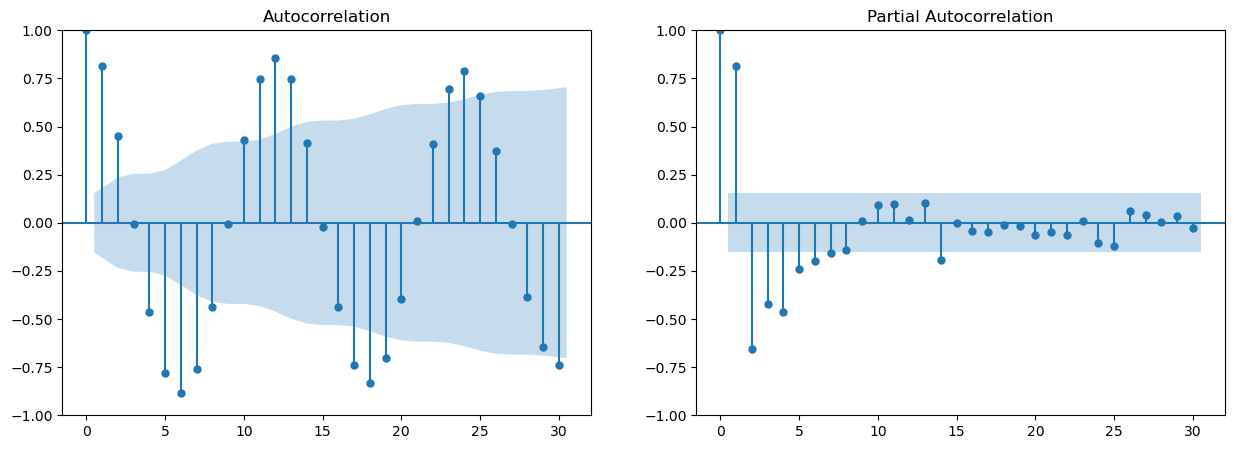

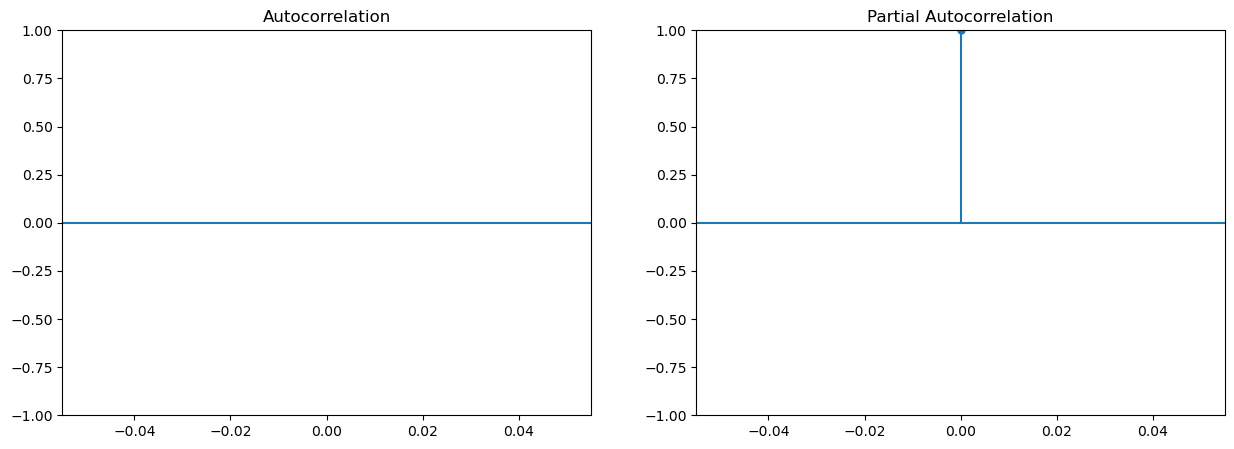

ADF Statistic: -2.9764799883196917
p-value: 0.03715002048738019
ADF Statistic (post diff): -6.708063604661569
p-value (post diff): 3.741067623155789e-09


In [87]:
selection_stationarity_diff(mean_wdat["tavg"], 30)

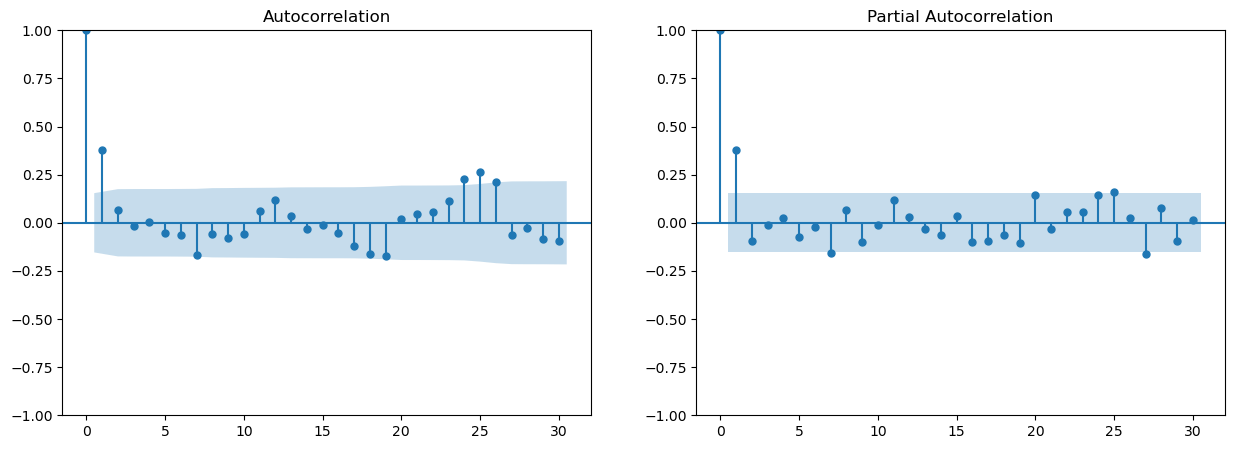

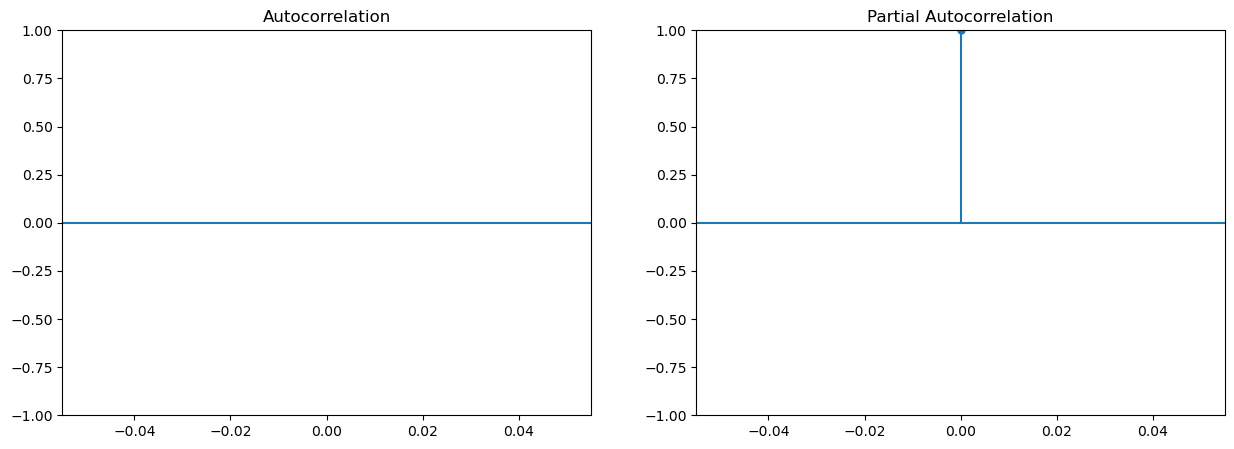

ADF Statistic: -8.469218769703668
p-value: 1.4933839148883957e-13
ADF Statistic (post diff): -7.232379957978777
p-value (post diff): 1.979227267457126e-10


In [88]:
selection_stationarity_diff(mean_wdat["wspd"], 30)

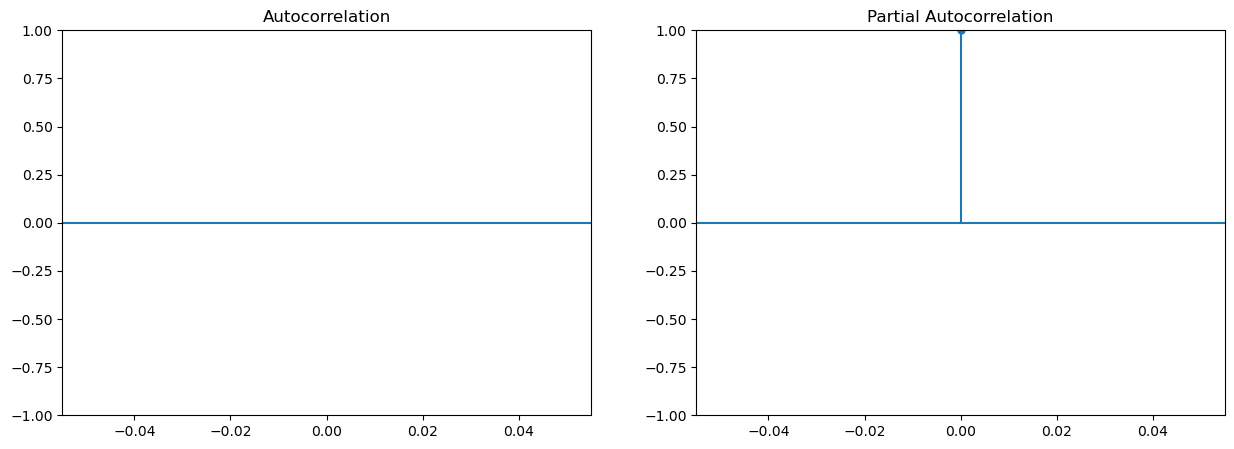

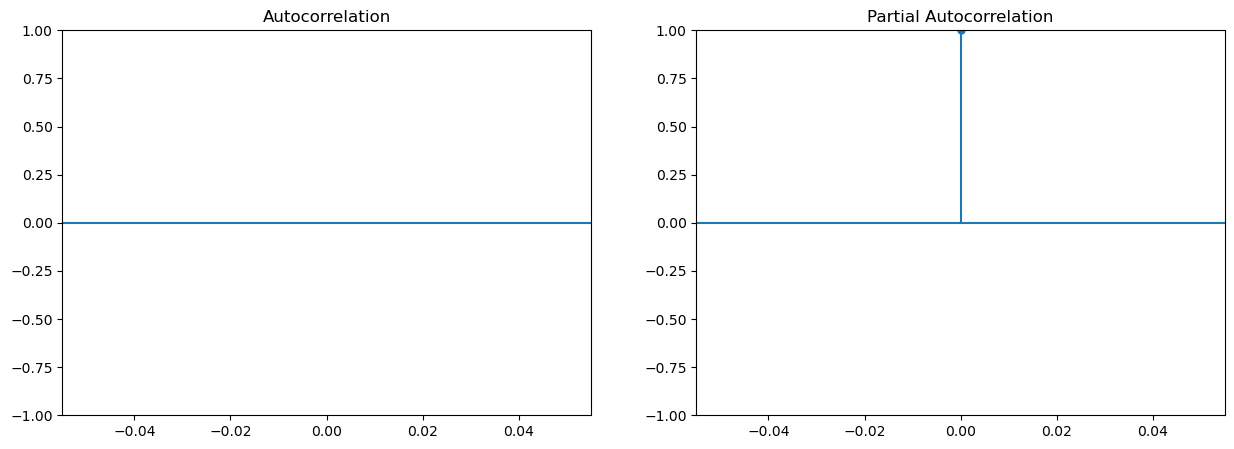

ADF Statistic: nan
p-value: nan
ADF Statistic (post diff): -10.86156679091665
p-value (post diff): 1.4419826132782327e-19


In [89]:
selection_stationarity_diff(mean_wdat["sun_eff"], 30)

Join the exogenous data with the time series data, and create the same train and test data.

In [90]:
ltex = ltts[ltts.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
ltex_train = ltex[ltex.index < pd.to_datetime("2022-01-01")]
ltex_test = ltex[(ltex.index >= pd.to_datetime("2022-01-01")) & (ltex.index < pd.to_datetime("2024-05-01"))]

## SARIMAX with Weather Data

Run the grid search.

In [91]:
# grid_search_sarimax(ltex_train["ND"], exog=ltex_train[["tavg", "wspd", "sun_eff"]])

Picks up the MA(2), still no AR, AIC good.

In [92]:
ltex_model = SARIMAX(ltex_train["ND"], exog=ltex_train[["tavg", "wspd", "sun_eff"]], order=(0,1,1), seasonal_order=(0,1,2,12))
ltex_fit = ltex_model.fit(disp=False, maxiter=1000, method="powell")
print(ltex_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      ND   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1000.119
Date:                                 Tue, 23 Jul 2024   AIC                           2014.238
Time:                                         17:48:14   BIC                           2033.692
Sample:                                     01-01-2011   HQIC                          2022.137
                                          - 12-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg        -417.2510     56.087     -7.439      0.000    -527.180    -307

sun_eff is significant!

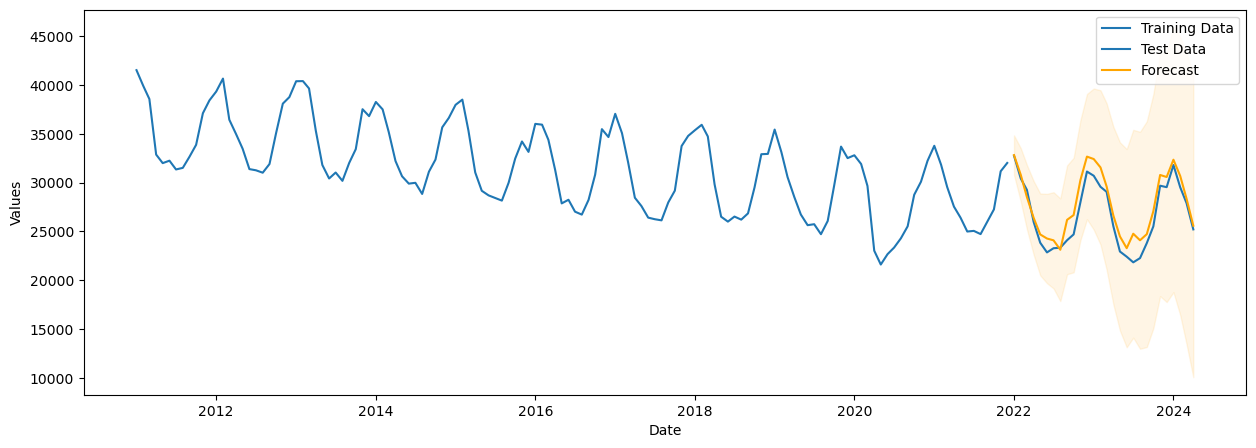

In [93]:
plot_fcast_sarimax(ltex_fit, ltex_train["ND"], ltex_test["ND"], ltex_test[["tavg", "wspd", "sun_eff"]])

In [94]:
rmse_mape(ltex_fit, ltex_test["ND"], ltex_test[["tavg", "wspd", "sun_eff"]])

Root Mean Squared Error: 1350.7185274845997
Mean Average Percentage Error: 4.503%


MAPE is down and good!

# STLF with SARIMAX

Essentially, I will do everything that I did with the previous model, but looking at daily data with a 7 day season.

In [95]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


In [96]:
stts = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [97]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [98]:
ldn_dwdat = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_dwdat = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_dwdat = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [99]:
sun_dfactor_09 = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_ddata = sun_dfactor_09[(sun_dfactor_09.index >= pd.to_datetime("2022-01-01")) & (sun_dfactor_09.index <= pd.to_datetime("2022-12-31"))]

combined_dwdat = pd.concat([ldn_dwdat, edi_dwdat, cdf_dwdat, sun_ddata], axis=1)

mean_dwdat = combined_dwdat.T.groupby(combined_dwdat.columns).agg("mean").T

In [100]:
mean_dwdat.head()

,sun_eff,tavg,wspd
2022-01-01,0.020661,12.833333,15.133333
2022-01-02,0.024186,10.100000,15.633333
2022-01-03,0.020500,8.233333,19.700000
2022-01-04,0.039364,3.500000,14.466667
2022-01-05,0.060809,3.033333,13.666667


In [101]:
stex = stts[((stts.index >= pd.to_datetime("2022-01-01")) & (stts.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
stex_train = stex[stex.index < pd.to_datetime("2022-08-09")]
stex_test = stex[stex.index >= pd.to_datetime("2022-08-09")]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


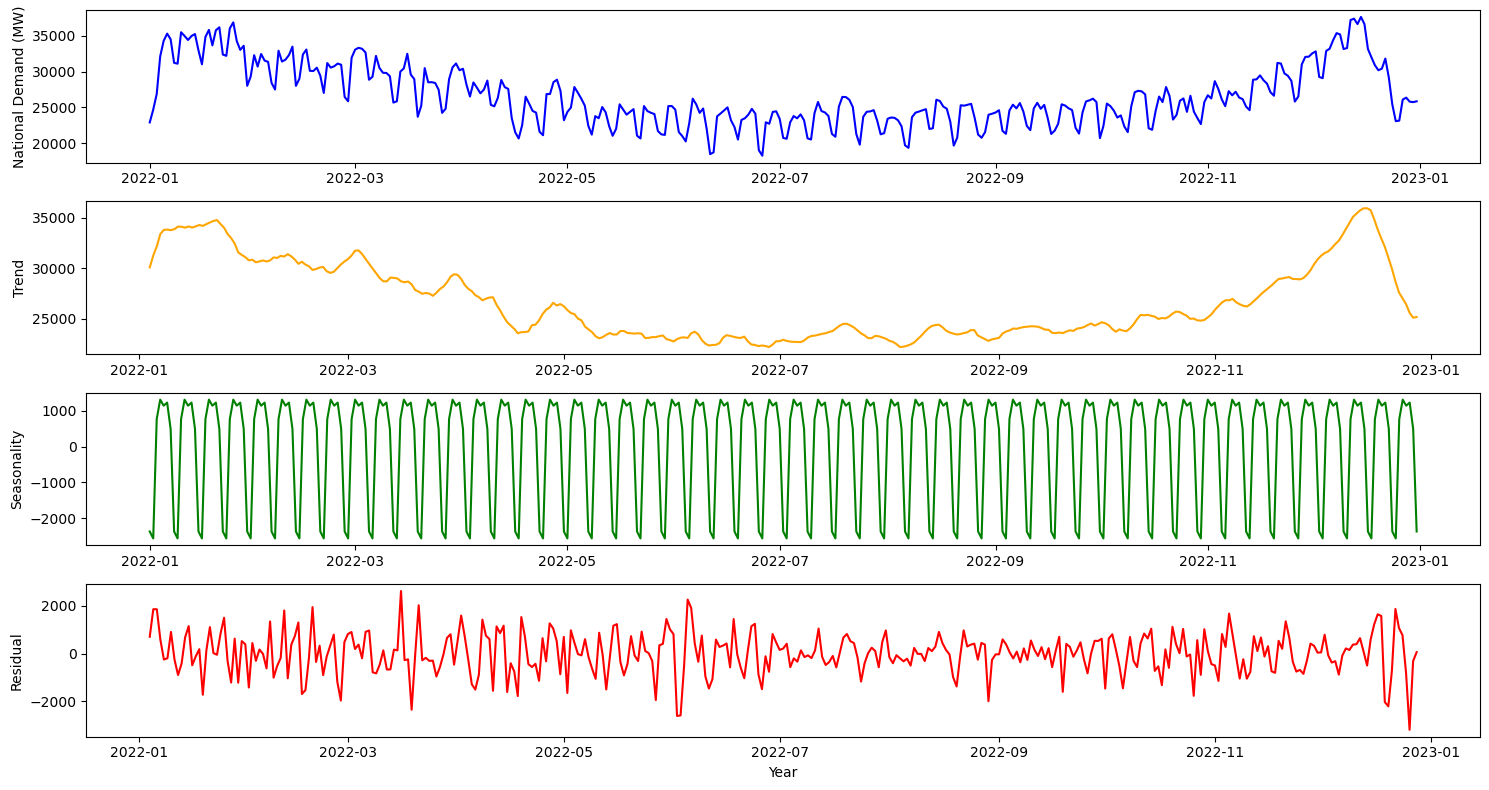

In [102]:
s_decomp_plot(stex["ND"], 7)

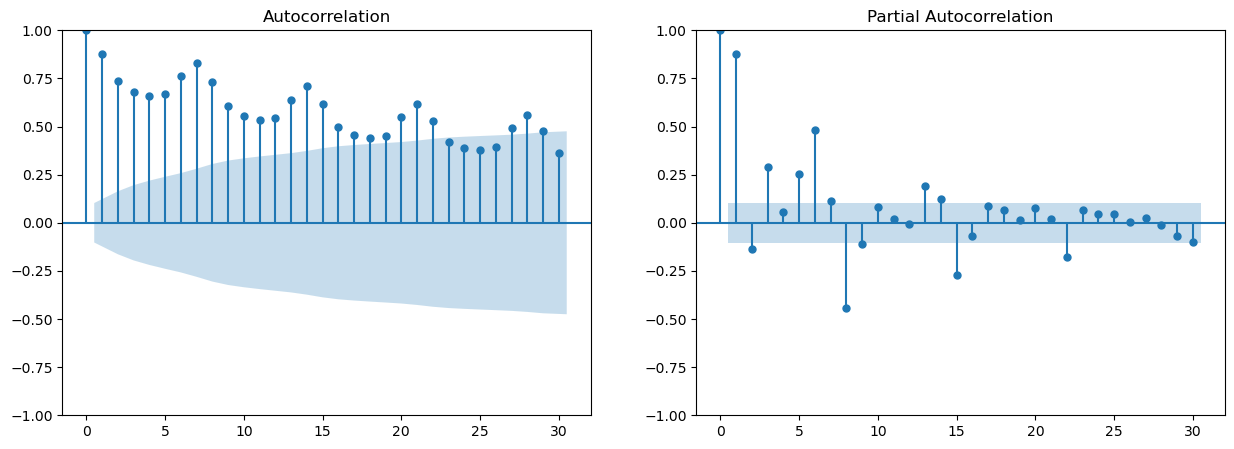

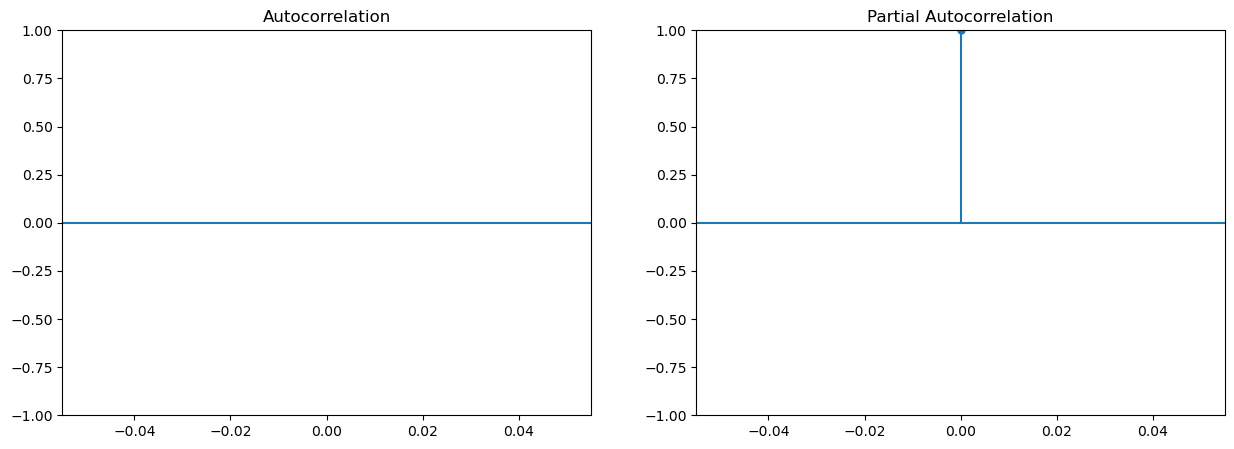

ADF Statistic: -2.2767601520749463
p-value: 0.1795728567768648
ADF Statistic (post diff): -5.371776117776565
p-value (post diff): 3.881567550472687e-06


In [103]:
selection_stationarity_diff(stex["ND"], 30)

Try not to run the grid search below, unless you have 15 minutes to spare!

In [104]:
# grid_search_sarima(agg_train_dly["ND"], exog=agg_train_dly[["tavg", "wspd", "sun_eff"]], q_list=list(range(5)), p_list=[0,1,2], s_period=[7])

If the output of the grid search fails to render, the output is:
```
Best pdq: (0, 1, 4)
Best PDQ: (0, 1, 4, 7)
AIC: 3525.612439985487
```

Also, ignore the UserWarnings: they are just to say that the model is self-correcting its parametrisation.

In [105]:
stex_model = SARIMAX(stex_train["ND"], exog=stex_train[["tavg", "wspd", "sun_eff"]], order=(0,1,4), seasonal_order=(0,1,4,7))
stex_fit = stex_model.fit(disp=False, maxiter=1000, method="powell")
print(stex_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                ND   No. Observations:                  220
Model:             SARIMAX(0, 1, 4)x(0, 1, 4, 7)   Log Likelihood               -1750.873
Date:                           Tue, 23 Jul 2024   AIC                           3525.745
Time:                                   17:48:17   BIC                           3566.024
Sample:                               01-01-2022   HQIC                          3542.025
                                    - 08-08-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tavg        -199.1080     36.457     -5.461      0.000    -270.563    -127.653
wspd        -118.9692     11.941     -9.963

The model is already looking worse in terms of AIC, but this is to be expected since there is a lot more data to forecast at a much higher frequency.

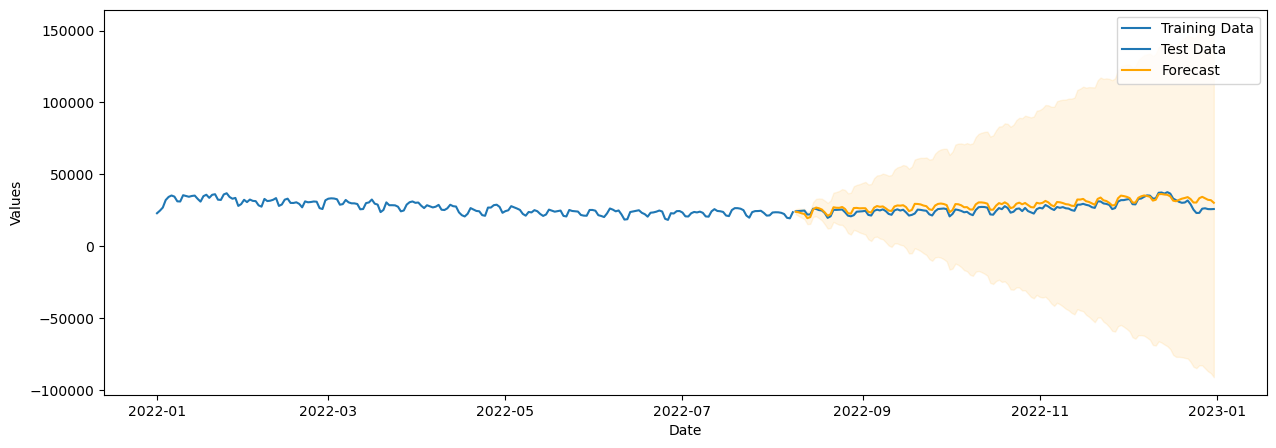

In [106]:
plot_fcast_sarimax(stex_fit, stex_train["ND"], stex_test["ND"], stex_test[["tavg", "wspd", "sun_eff"]])

In [107]:
rmse_mape(stex_fit, stex_test["ND"], stex_test[["tavg", "wspd", "sun_eff"]])

Root Mean Squared Error: 3202.759917541996
Mean Average Percentage Error: 11.145%


Again, these numbers are terrible, but that's what we hope to fix with the machine learning models.